### **Part 3: WGAN-GP for Unpaired Image-to-Image Translation** (15 points)  

#### **Task Overview**  
In this part, you will implement a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** to perform unpaired domain transfer between colored MNIST digits. Unlike CycleGAN (discussed in class), your solution must rely solely on:  
- **WGAN-GP losses** (discriminator/critic + gradient penalty),  
- **L1 regularization** $\lambda_1\|{\color{blue}G_\theta}(x)-x\|_1$.  

#### **Key Constraints**  
❌ **Prohibited techniques**:  
- Cycle-consistency loss (used in CycleGAN),  
- Pix2Pix losses (paired training assumptions).  

#### **Resources**  
For additional explanation WGANs except lectures and seminars, refer to tutorial: [*From GAN to WGAN*](https://lilianweng.github.io/posts/2017-08-20-gan/).


In [ ]:
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## 1. Dataset Preparation (2 points)

You should
1. Load the MNIST dataset using `torchvision.datasets`
2. Adapt the seminar's dataset class for our setup
3. Configure:
   - Source domain: Digit `2`
   - Target domain: Digit `3`
4. Generate and visualize a batch of samples from both source and target domains

In [ ]:
# Assign random color to  gray-scaled image
def random_color(im: torch.Tensor) -> torch.Tensor:
    hue = 360 * np.random.rand()
    d = im * (hue % 60) / 60
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    H = round(hue / 60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

In [ ]:
class CMNISTDataset(Dataset):
    def __init__(
        self,
        digit: int = 0,
        train: bool = True,
        spat_dim: tuple[int, int] = (16, 16),
        download: bool = False,
        pix_range: tuple[float, float] = (-1.0, 1.0),
    ) -> None:
        # YOUR CODE HERE
        ...

    def __len__(self):
        return ... # YOUR CODE HERE

    def __getitem__(self, idx: int) -> torch.Tensor:
        return ... # YOUR CODE HERE

In [ ]:
SOURCE_DIGIT = 2
TARGET_DIGIT = 3

In [ ]:
source_train = ... # YOUR CODE HERE
target_train = ... # YOUR CODE HERE

print(f"Source train: {len(source_train)} images")
print(f"Target train: {len(target_train)} images")

Source train: 5958 images
Target train: 6131 images


In [ ]:
def plot_images(batch: torch.Tensor, title: str | None = None) -> None:
    # YOUR CODE HERE
    ...

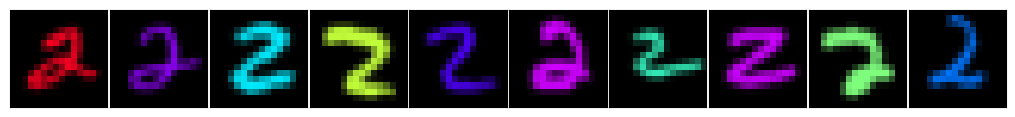

In [8]:
SOURCE_IMAGES = next(iter(DataLoader(source_train, batch_size=10)))
plot_images(SOURCE_IMAGES)

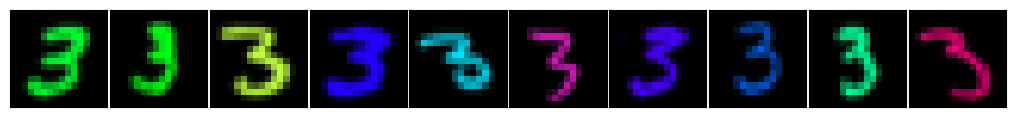

In [9]:
TARGET_IMAGES = next(iter(DataLoader(target_train, batch_size=10)))
plot_images(TARGET_IMAGES)

## 2. Implement the GAN Generator and Discriminator (3 points)

You can use the WGAN architectures from the seminar for image-to-image translation or utilize proposed structure. Your implementation should include:

1. Generator ${\color{blue}G_\theta}(x)$: Takes a `colored MNIST` image $x$ as input
2. Discriminator ${\color{red}D_\omega}(x)$: Standard unconditional discriminator

For architecture reference, you can check these repositories:
- C-WGAN-GP: https://github.com/HayatiYrtgl/C-WGAN-GP/tree/main
- Neural Optimal Transport: https://github.com/iamalexkorotin/NeuralOptimalTransport/tree/main

You may also look up other WGAN-GP implementations online.

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder (16x16 -> 4x4)
        self.enc1 = nn.Sequential(
            ... # YOUR CODE HERE
        )
        self.enc2 = nn.Sequential(
            ... # YOUR CODE HERE
        )

        # Residual blocks (4x4)
        self.res = nn.Sequential(
            ... # YOUR CODE HERE
        )

        # Decoder (4x4 -> 16x16)
        self.dec1 = nn.Sequential(
            ... # YOUR CODE HERE
        )
        self.dec2 = nn.Sequential(
            ... # YOUR CODE HERE  # Output in [-1, 1]
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        # Residual
        res = ... # YOUR CODE HERE # Skip connection
        # Decoder
        d1 = self.dec1(res)
        d2 = self.dec2(d1)
        return d2

In [ ]:
class Critic(nn.Module):
    def __init__(self, in_channels: int = 3):
        super().__init__()
        self.model = nn.Sequential(
            # Input: [3, 16, 16]
            ... # YOUR CODE HERE
        )

    def forward(self, x):
        return ... # YOUR CODE HERE

## 3. Implement GAN Model Training (6 points)  

Use **WGAN-GP loss** as the GAN loss. Additionally, train the **WGAN-GP** with $L_1$ regularization, defined as the norm of the difference between the input $x$ and generated ${\color{blue}G_\theta}(x)$ images: $\|{\color{blue}G_\theta}(x)-x\|_1$.  

**Auxiliary utils**. You can use the functions in the cell below to track the GAN training progress. 

In [12]:
def compute_gradient(
    input_tensor: torch.Tensor, output_tensor: torch.Tensor, create_graph: bool = True, retain_graph: bool = True
) -> torch.Tensor:
    """
    Compute gradient of output with respect to input in batch manner.

    Args:
        input_tensor: Input tensor of shape (batch_size, *shape)
        output_tensor: Output tensor of shape (batch_size, 1)
        create_graph: Whether to create computation graph
        retain_graph: Whether to retain computation graph

    Returns:
        Gradient tensor of shape (batch_size, *shape)
    """
    gradients = torch.autograd.grad(
        outputs=output_tensor,
        inputs=input_tensor,
        grad_outputs=torch.ones_like(output_tensor),
        create_graph=create_graph,
        retain_graph=retain_graph,
    )
    return gradients[0]

In [13]:
def generate_gan_metrics(
    generator: nn.Module,
    critic: nn.Module,
    n_samples: int = 5000,
    grid_size: int = 1000,
    compute_grad_norms: bool = True,
):
    """
    Generate evaluation metrics for GAN performance.

    Args:
        generator: Generator model
        critic: Critic/Discriminator model
        n_samples: Number of samples to generate
        grid_size: Size of evaluation grid
        compute_grad_norms: Whether to compute gradient norms

    Returns:
        Tuple containing samples, grid, critic outputs, and optionally gradient norms
    """
    generator.eval()
    critic.eval()

    xs = np.linspace(-3.0, 3.0, grid_size + 1)
    xg, yg = np.meshgrid(xs, xs)
    grid = np.stack((xg.ravel(), yg.ravel()), axis=-1)

    device = next(generator.parameters()).device
    grid_tensor = torch.FloatTensor(grid).to(device)

    with torch.no_grad():
        samples = generator.sample(n_samples).cpu().numpy()
        critic_output = critic(grid_tensor).cpu().numpy()

    if compute_grad_norms:
        grid_tensor.requires_grad_(True)
        critic_output_tensor = critic(grid_tensor)
        gradients = compute_gradient(grid_tensor, critic_output_tensor, create_graph=False, retain_graph=False)
        grad_norms = torch.norm(gradients, dim=-1).cpu().numpy()
        grad_norms = grad_norms.reshape((grid_size + 1, grid_size + 1))

        return samples, grid, critic_output.reshape(-1), grad_norms

    return samples, grid, critic_output.reshape(-1)

In [14]:
def plot_gan_results(
    generated_samples: np.ndarray,
    real_samples: np.ndarray,
    grid: np.ndarray,
    critic_output: np.ndarray,
    critic_grad_norms: np.ndarray,
):
    """
    Visualize GAN training results.

    Args:
        generated_samples: Samples from generator
        real_samples: Ground truth samples
        grid: Evaluation grid
        critic_output: Critic outputs over grid
        critic_grad_norms: Critic gradient norms over grid
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    n_points = int(np.sqrt(len(grid)))

    cnt1 = ax1.contourf(
        grid[:, 0].reshape((n_points, n_points)),
        grid[:, 1].reshape((n_points, n_points)),
        critic_output.reshape((n_points, n_points)),
        levels=25,
        cmap="cividis",
    )
    ax1.scatter(real_samples[:, 0], real_samples[:, 1], marker="x", color="blue", s=0.5, label="Real samples")
    ax1.scatter(
        generated_samples[:, 0], generated_samples[:, 1], marker=".", color="red", s=0.5, label="Generated samples"
    )
    ax1.set_title("Critic Outputs", fontsize=16)
    ax1.legend(fontsize=12)
    fig.colorbar(cnt1, ax=ax1)

    cnt2 = ax2.contourf(
        grid[:, 0].reshape((n_points, n_points)),
        grid[:, 1].reshape((n_points, n_points)),
        critic_grad_norms,
        levels=25,
        cmap="cividis",
    )
    ax2.set_title("Critic Gradient Norms", fontsize=16)
    fig.colorbar(cnt2, ax=ax2)

    plt.tight_layout()
    plt.show()

In [15]:
class GANTrainingMonitor(ABC):
    """Base class for monitoring GAN training progress."""

    def __init__(self, generator: nn.Module, discriminator: nn.Module, reference_data: np.ndarray):
        self.generator = generator
        self.discriminator = discriminator
        self.reference_data = reference_data
        self.generator_losses = []
        self.discriminator_losses = []
        self.device = next(generator.parameters()).device

    def upd_g_loss(self, loss: float):
        self.generator_losses.append(loss)

    def upd_d_loss(self, loss: float):
        self.discriminator_losses.append(loss)

    def plot_losses(self):
        """Plot generator and discriminator loss curves."""
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        for ax, losses, title in zip(
            (ax1, ax2), (self.generator_losses, self.discriminator_losses), ("Generator Loss", "Discriminator Loss")
        ):
            ax.plot(losses)
            ax.set_title(title, fontsize=16)
            ax.set_xlabel("Iteration", fontsize=14)
            ax.set_ylabel("Loss", fontsize=14)
            ax.grid(True)
            ax.tick_params(labelsize=12)

        plt.tight_layout()
        plt.show()

    @abstractmethod
    def visualize(self):
        """Visualize training progress."""
        self.plot_losses()


class GAN2DMonitor(GANTrainingMonitor):
    """Monitor for 2D GAN training."""

    def visualize(self):
        """Visualize 2D GAN results."""
        super().visualize()
        samples, grid, critic_output, grad_norms = generate_gan_metrics(self.generator, self.discriminator)
        plot_gan_results(samples, self.reference_data, grid, critic_output, grad_norms)


class GANImageMonitor(GANTrainingMonitor):
    """Monitor for image-based GAN training."""

    def visualize(self):
        """Visualize image GAN results."""
        clear_output()
        super().visualize()
        plot_images(self.reference_data.cpu(), "Real Samples")
        generated = self.generator(self.reference_data.to(self.device)).detach().cpu()
        plot_images(generated, "Generated Samples")

### 3.1 WGAN-GP Training (4 points)

Implement WGAN-GP training using the seminar's reference code as your starting point and train model.

In [ ]:
def wgp_gen_step(
    X: torch.Tensor,  # random batch from the dataset
    G: nn.Module,  # generator model
    D: nn.Module,  # critic model
    G_optim: optim.Optimizer,  # optimizer for generator (Adam/RMSprop/SGD etc.)
) -> torch.Tensor:  # returns the value of loss to track the training statistics
    ...  # YOUR CODE HERE

In [ ]:
def wgp_discr_step(
    X: torch.Tensor,  # Source images (e.g., input to generator)
    Y: torch.Tensor,  # Target images (real data)
    G: nn.Module,  # Generator (image-to-image)
    D: nn.Module,  # Critic (not Discriminator)
    D_optim: optim.Optimizer,
    gp_lambda: float = 10.0,  # Default GP weight (not a Tensor)
) -> float:  # Returns loss for logging
    ... # YOUR CODE HERE

In [ ]:
def train_wgp(
    source_loader: DataLoader,  # dataloader of source dataset
    target_loader: DataLoader,  # dataloader of target dataset
    G: nn.Module,  # generator model
    D: nn.Module,  # critic model
    G_optim: optim.Optimizer,  # optimizer for the generator
    D_optim: optim.Optimizer,  # optimizer for the critic
    critic_steps: int,  # number of discriminators steps per each generator step
    n_epochs: int,  # number of training epochs
    diagnostic: GANTrainingMonitor,  # tracking statistics & visualization
    gp_lambda: torch.Tensor = torch.tensor(10.0),  # gradient penalty coefficient
    visualize_steps: int = 10,  # for visualization purposes
) -> None:
    ... # YOUR CODE HERE

In [ ]:
BATCH_SIZE = ... # YOUR CODE HERE
CRITIC_STEPS = ... # YOUR CODE HERE
LR = ... # YOUR CODE HERE # < 1e-2
N_EPOCHS = ... # YOUR CODE HERE
GP_LAMBDA = ... # YOUR CODE HERE

In [ ]:
source_cmnist_loader = ... # YOUR CODE HERE
target_cmnist_loader = ... # YOUR CODE HERE
G = ... # YOUR CODE HERE
D = ... # YOUR CODE HERE
G_optim = ... # YOUR CODE HERE
D_optim = ... # YOUR CODE HERE
diagnostic = ... # YOUR CODE HERE

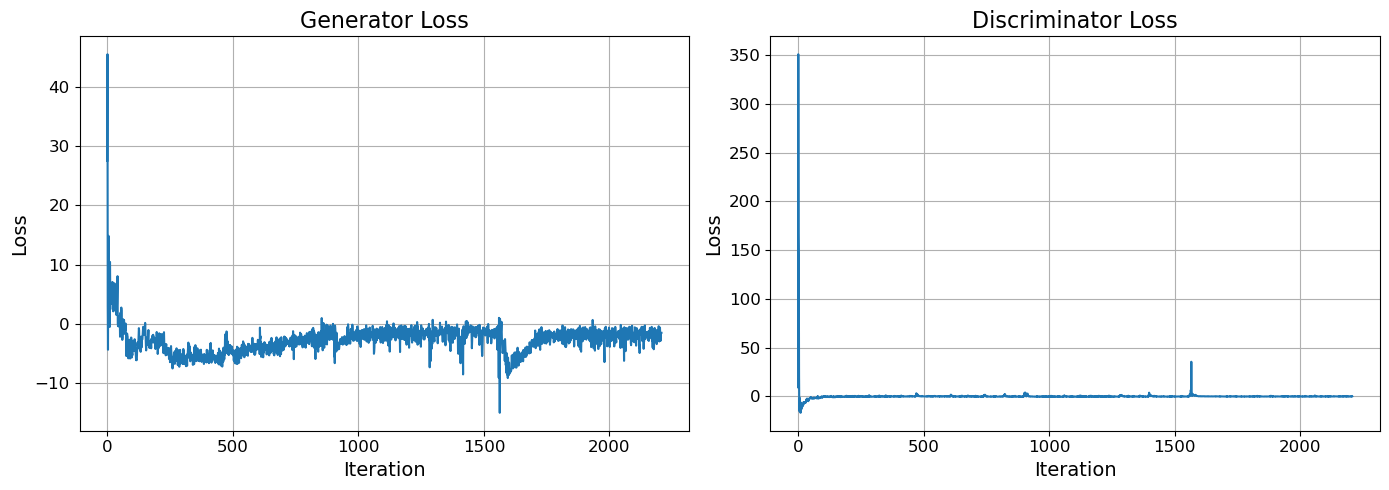

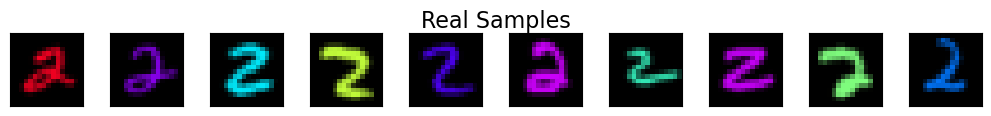

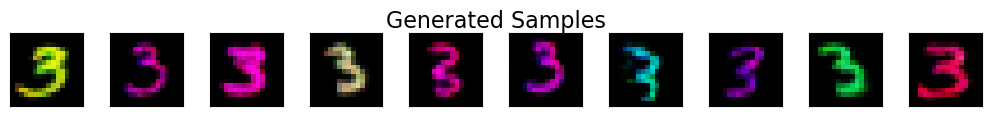

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:15<00:00,  3.16s/it]


In [57]:
train_losses = train_wgp(
    source_cmnist_loader,
    target_cmnist_loader,
    G,
    D,
    G_optim,
    D_optim,
    critic_steps=CRITIC_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    gp_lambda=torch.tensor(GP_LAMBDA).to(DEVICE),
    visualize_steps=5
)

### 3.2 WGAN-GP with $L_1$ Regularization (2 points)  

Implement and train a **WGAN-GP** model with **$L_1$ regularization**. Modify the WGAN-GP loss to include an $L_1$ penalty term:  
   - Total Loss = WGAN-GP Loss + $\lambda_1 \cdot \|{\color{blue}G_\theta}(x) - x \|_1$  
   - Where $\lambda_1$ controls the regularization strength  
 

In [ ]:
def wgp_gen_step_with_l1_reg(
    X: torch.Tensor,  # Input batch (e.g., source images for translation)
    G: nn.Module,  # Generator
    D: nn.Module,  # Critic (WGAN-GP uses a critic, not a discriminator)
    G_optim: torch.optim.Optimizer,
    l1_lambda: float = 10,  # Weight for L1 loss (adjust based on your task)
) -> float:  # Returns loss value for logging
    ...  # YOUR CODE HERE

In [ ]:
def train_wgp_with_l1_reg(
    source_loader: DataLoader,  # dataloader of source dataset
    target_loader: DataLoader,  # dataloader of target dataset
    G: nn.Module,  # generator model
    D: nn.Module,  # critic model
    G_optim: torch.optim.Optimizer,  # optimizer for the generator
    D_optim: torch.optim.Optimizer,  # optimizer for the critic
    critic_steps: int,  # number of discriminators steps per each generator step
    n_epochs: int,  # number of training epochs
    diagnostic: GANTrainingMonitor,  # tracking statistics & visualization
    gp_lambda: torch.Tensor = torch.tensor(10.0),  # gradient penalty coefficient
    visualize_steps: int = 10,  # for visualization purposes
) -> None: ...  # YOUR CODE HERE

In [ ]:
BATCH_SIZE = ... # YOUR CODE HERE
CRITIC_STEPS = ... # YOUR CODE HERE
LR = ... # YOUR CODE HERE # < 1e-2
N_EPOCHS = ... # YOUR CODE HERE
GP_LAMBDA = ... # YOUR CODE HERE

In [ ]:
source_cmnist_loader = ... # YOUR CODE HERE
target_cmnist_loader = ... # YOUR CODE HERE
G_L1 = ... # YOUR CODE HERE
D_L1 = ... # YOUR CODE HERE
G_L1_optim = ... # YOUR CODE HERE
D_L1_optim = ... # YOUR CODE HERE
diagnostic = ... # YOUR CODE HERE

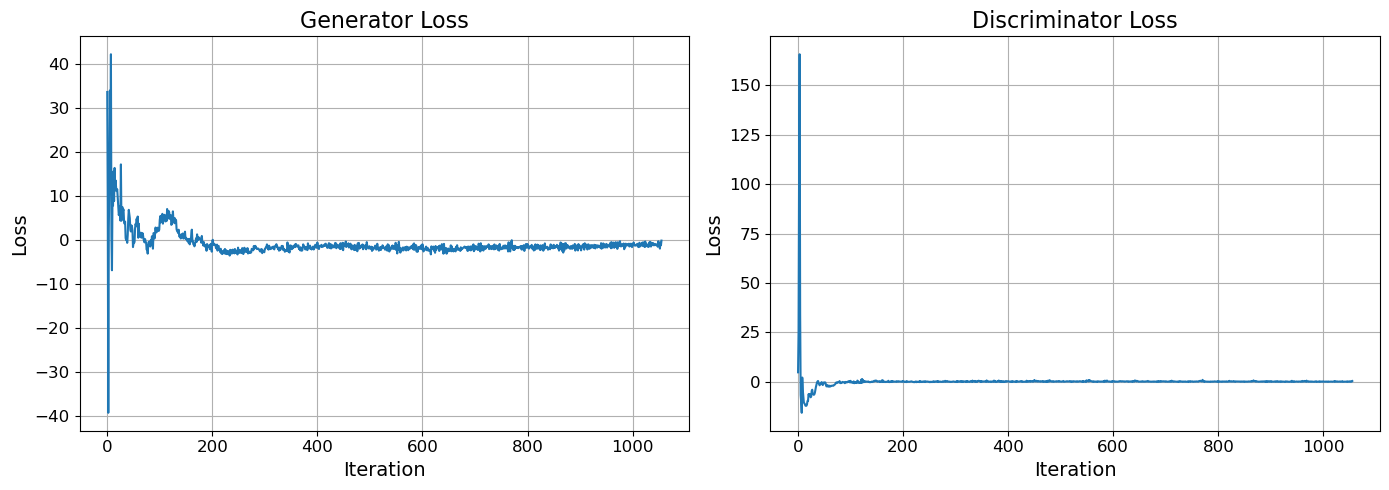

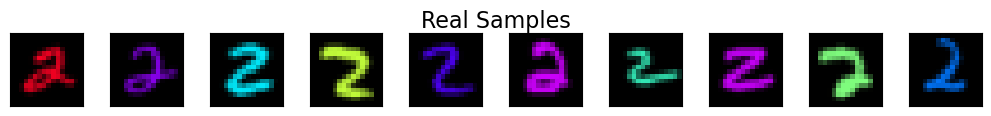

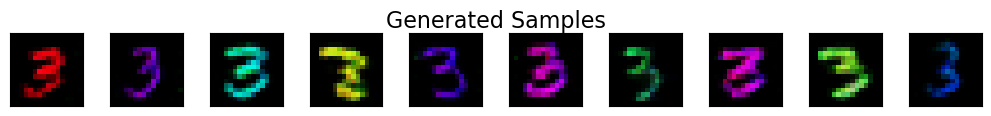

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.10s/it]


In [25]:
train_losses = train_wgp_with_l1_reg(
    source_cmnist_loader,
    target_cmnist_loader,
    G_L1,
    D_L1,
    G_L1_optim,
    D_L1_optim,
    critic_steps=CRITIC_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    gp_lambda=torch.tensor(GP_LAMBDA).to(DEVICE),
    visualize_steps=5
)

## 4. Model Evaluation (4 points)  

1. **Metric Implementation (3 points)**  
   - Compute the **CMMD (Conditional Maximum Mean Discrepancy)** metric from:  
     [*Rethinking FID: Towards a Better Evaluation Metric for Image Generation*](https://arxiv.org/pdf/2401.09603)  
   - Apply it to assess your model’s performance on the **MNIST test set**.  

2. **Qualitative Visualization (0.5 points)**  
   - Generate and plot domain transfer results (digit **2 $\to$ 3**) for the **ColoredMNIST** dataset.  

3. **Analysis (0.5 points)**  
   - Summarize key observations (e.g., mode collapse, artifacts, or successful transfers).  

### 4.1 Computing CMMD Scores (3 points)

For this part, please use the PyTorch version of CMMD from [this GitHub repo](https://github.com/sayakpaul/cmmd-pytorch/tree/main). It's a direct translation of the original [Google Research JAX implementation](https://github.com/google-research/google-research/tree/master/cmmd), just in PyTorch.

A quick heads-up - we'd really appreciate it if you could stick to this exact implementation. When everyone uses the same codebase, it makes it much easier for the TAs to check your work and give you fair grades. Please try to keep the core CMMD calculation part as-is.

In [ ]:
# The bandwidth parameter for the Gaussian RBF kernel. See the paper for more
# details.
_SIGMA = ... # YOUR CODE HERE
# The following is used to make the metric more human readable. See the paper
# for more details.
_SCALE = ... # YOUR CODE HERE

In [ ]:
def mmd(x: np.ndarray, y: np.ndarray) -> torch.Tensor:
    # YOUR CODE HERE
    ...

Install necessaty libraries.

In [28]:
!pip install transformers accelerate -q

In [ ]:
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection

_CLIP_MODEL_NAME = ... # YOUR CODE HERE
_CUDA_AVAILABLE = ... # YOUR CODE HERE


def _resize_bicubic(images, size):
    ... # YOUR CODE HERE


class ClipEmbeddingModel:
    """CLIP image embedding calculator."""

    ... # YOUR CODE HERE

In [ ]:
def compute_embeddings(
    dataset: Dataset,
    embedding_model: ClipEmbeddingModel,
    batch_size: int = 32,
    max_samples: int = None,
) -> np.ndarray:
    """
    Compute embeddings for a dataset in batches.
    
    Args:
        dataset: Input dataset
        embed_fn: Function that takes images and returns embeddings
        batch_size: Number of samples per batch
        max_samples: Maximum number of samples to process
        
    Returns:
        Array of embeddings with shape (num_samples, embedding_dim)
    """
    # YOUR CODE HERE
    ...

In [ ]:
source_test = ... # YOUR CODE HERE
target_test = ... # YOUR CODE HERE

In [ ]:
embedding_model = ... # YOUR CODE HERE
TEST_BATCH_SIZE = ... # YOUR CODE HERE

In [ ]:
gt_embs = ... # YOUR CODE HERE

Processing 1010 images...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 31/32 [00:24<00:00,  1.27it/s]


In [ ]:
def generate_images(
    dataset: Dataset,
    G: nn.Module,
    batch_size: int,
    device: torch.device = DEVICE,
) -> torch.Tensor:
    """
    Generate images using a trained generator model.

    Args:
        dataset: Input dataset containing source images
        generator: Trained generator model
        batch_size: Number of images to process per batch
        input_range: Range of generator's output
        output_range: Desired output range
        device: Device to run computation on

    Returns:
        Tensor containing all generated images (shape: [N, C, H, W]) from [0, 1]
    """
    # YOUR CODE HERE
    ...

In [ ]:
wgan_gp_generated_test = ... # YOUR CODE HERE
wgan_gp_emb = ... # YOUR CODE HERE

Generating images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 113.56it/s]


Processing 1024 images...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 31/33 [00:24<00:01,  1.25it/s]


In [ ]:
wgan_gp_l1_generated_test = ... # YOUR CODE HERE
wgan_gp_l1_emb = ... # YOUR CODE HERE

Generating images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 111.83it/s]


Processing 1024 images...


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 31/33 [00:24<00:01,  1.26it/s]


In [ ]:
wgan_gp_cmmd = ... # YOUR CODE HERE
print(f"CMMD for WGAN-GP on ColoredMNIST: {wgan_gp_cmmd}")

CMMD for WGAN-GP on ColoredMNIST: 3.5871267318725586


In [ ]:
wgan_gp_l1_cmmd = ... # YOUR CODE HERE
print(f"CMMD for WGAN-GP with L1 regularization on ColoredMNIST: {wgan_gp_l1_cmmd}")

CMMD for WGAN-GP with L1 regularization on ColoredMNIST: 0.18155574798583984


### 4.2 Qualitative results of GAN model (0.5 points)

Plot obtained images.

In [ ]:
SOURCE_TEST = ... # YOUR CODE HERE

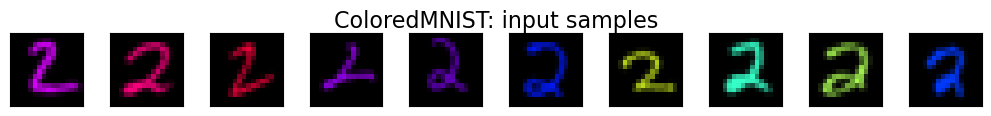

In [ ]:
plot_images(...,'ColoredMNIST: input samples') # YOUR CODE HERE

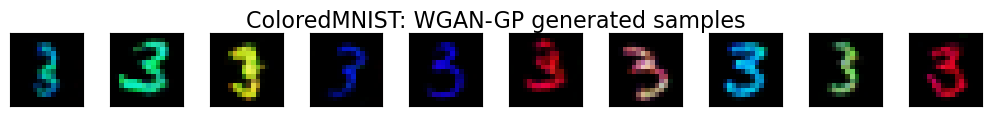

In [ ]:
plot_images(...,'ColoredMNIST: WGAN-GP generated samples') # YOUR CODE HERE

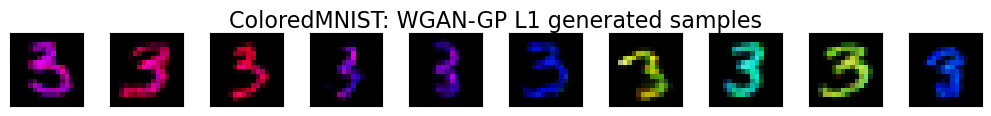

In [ ]:
plot_images(...,'ColoredMNIST: WGAN-GP L1 generated samples') # YOUR CODE HERE

### 4.3 Summary (0.5 points)

**Observations:** YOUR OBSERVATIONS HERE.